In [ ]:
import random
import time
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
# Define constants for Network Intiallization
IPRange = 50
IPSize = 15
timeout = 500
routeQtd = 8
destinationHost = "192.168.1.100"
sourceHost = "192.168.1.1"
selectionQtd = 4
lastDestinationOc = 100
lastSourceOc = 1

In [ ]:
# Router Class
class Router:
    def __init__(self, ip, lastBinOc, nextTime, fitness):
        self.ip = ip
        self.nextRtd = None
        self.lastBinOc = lastBinOc
        self.nextTime = nextTime
        self.fitness = fitness
        self.jitter = 0


In [ ]:
# Route Class
class Route:
    def __init__(self):
        self.firstRouter = None
        self.routeTime = 0
        self.fitnessSum = 0.0

In [ ]:
# Function to remove repeated routers in the route
def remove_repeated(way):
    for i in range(routeQtd):
        iterator = way[i].firstRouter.nextRtd
        while iterator.nextRtd is not None:
            comparator = iterator.nextRtd
            while comparator.nextRtd is not None:
                if comparator.ip == iterator.ip:
                    remover = way[i].firstRouter.nextRtd
                    while remover.nextRtd != comparator:
                        remover = remover.nextRtd
                    remover.nextRtd = comparator.nextRtd
                    del comparator
                    break
                comparator = comparator.nextRtd
            iterator = iterator.nextRtd


In [ ]:
# Function to create router with a given IP and last octet
def create_router(ip, lastIntOc):
    lastCharOc = format(lastIntOc, '08b')
    new_router = Router(ip, lastCharOc, random.randint(20, timeout), 0.0)
    return new_router


In [ ]:
# Function to initialize a route
def initialize_route():
    new_route = Route()
    rtd = create_router(sourceHost, lastSourceOc)
    new_route.firstRouter = rtd
    new_route.routeTime = 0
    return new_route


In [ ]:
# Function to add a router to a route
def add_router(way, ip, lastIntOc):
    iterator = way.firstRouter
    aux = create_router(ip, lastIntOc)

    while iterator.nextRtd is not None:
        iterator = iterator.nextRtd

    iterator.nextRtd = aux


In [ ]:
# Function to detect repeated routers in a route
def detect_repeated(way, ip):
    iterator = way.firstRouter
    while iterator.nextRtd is not None:
        if iterator.ip == ip:
            return 0
        iterator = iterator.nextRtd
    if iterator.ip == ip:
        return 0
    return -1

In [ ]:
# Function to construct a route
def mount_route():
    way = initialize_route()

    for _ in range(random.randint(3, IPRange + 2)):
        lastIntOc = random.randint(3, IPRange + 2)
        lastOc = str(lastIntOc)
        ip = "192.168.1." + lastOc

        if detect_repeated(way, ip) == -1:
            add_router(way, ip, lastIntOc)

    aux = way.firstRouter

    while aux.nextRtd is not None:
        aux = aux.nextRtd

    if aux.nextRtd is None:
        last = create_router(destinationHost, lastDestinationOc)
        last.nextTime = -1
        aux.nextRtd = last

    aux = way.firstRouter

    while aux.nextTime != -1:
        way.routeTime += aux.nextTime
        aux = aux.nextRtd

    return way


In [ ]:
# Function for population initialization of routes
def initialize():
    way = mount_route()
    return way



In [ ]:
# Function to display information about routes - Total Time and Route Fitness Value
def show(way):
    for i in range(routeQtd):
        print(f"Route {i + 1}\n")
        aux = way[i].firstRouter

        while aux is not None:
            print(f"IP: {aux.ip} - Latency to next router: {aux.nextTime}ms - Last octet binary: {aux.lastBinOc} - Fitness Jump: {aux.fitness}")
            aux = aux.nextRtd

        print(f"Total Time: {way[i].routeTime}ms")
        print(f"Route Fitness: {way[i].fitnessSum}\n\n")



In [ ]:
# Function to update total latencies in each route
def update_total_latencies(way):
    for i in range(routeQtd):
        iterator = way[i].firstRouter
        way[i].routeTime = 0
        last_time = None
        while iterator.nextRtd is not None:
            if last_time is not None:
                iterator.jitter = abs(iterator.nextTime - last_time)
            last_time = iterator.nextTime
            way[i].routeTime += iterator.nextTime
            iterator = iterator.nextRtd


In [ ]:
IPRange = 50
routeQtd = 8
destinationHost = "192.168.1.100"
sourceHost = "192.168.1.1"
lastDestinationOc = 100
lastSourceOc = 1


In [ ]:
# Function for fitness evaluation
def evaluate_fitness(way):
    for i in range(routeQtd):
        iterator = way[i].firstRouter
        way[i].fitnessSum = 0

        while iterator.nextRtd is not None:
            latency_fitness = 1.0 / iterator.nextTime
            jitter_fitness = 1.0 / (iterator.jitter + 0.00001)
            iterator.fitness = latency_fitness + jitter_fitness

            iterator = iterator.nextRtd

        way[i].fitnessSum = 1.0 / (way[i].routeTime + 0.00001)



In [ ]:
# Function to perform elitism
def make_elitism(way):
    iterator = way[routeQtd - 2].firstRouter.nextRtd
    faster = iterator
    smallerTime = iterator.nextTime

    while iterator.nextRtd is not None:
        if smallerTime > iterator.nextTime:
            smallerTime = iterator.nextTime
            faster = iterator
        iterator = iterator.nextRtd

    iterator = way[routeQtd - 1].firstRouter.nextRtd
    slower = iterator
    greaterTime = iterator.nextTime

    while iterator.nextRtd is not None:
        if greaterTime < iterator.nextTime:
            greaterTime = iterator.nextTime
            slower = iterator
        iterator = iterator.nextRtd

    slower.ip = faster.ip
    slower.nextTime = faster.nextTime
    slower.lastBinOc = faster.lastBinOc
    slower.fitness = faster.fitness



In [ ]:
# Function to count routers in a route
def count_routers_in_route(route):
    count = 0
    iterator = route.firstRouter

    while iterator is not None:
        count += 1
        iterator = iterator.nextRtd

    return count

In [ ]:
# Crossover Function
def make_crossover(way):
    routes_size = [count_routers_in_route(way[i]) for i in range(routeQtd)]

    smaller_route = min(routes_size)

    crossoved = [0 for _ in range(routeQtd)]
    method = random.randint(0, 2)

    for i in range(routeQtd):
        if method == 1:
            if crossoved[i] == 0:
                separation_point = 1 + random.randint(1, smaller_route)
                print(f"SEPARATION POINT {i + 1} - {i + 3}: {separation_point}")
                if smaller_route == separation_point or separation_point > smaller_route:
                    separation_point = 1

                iterator_route1 = way[i].firstRouter
                iterator_route2 = way[i + 2].firstRouter

                for j in range(separation_point - 1):
                    iterator_route1 = iterator_route1.nextRtd
                    iterator_route2 = iterator_route2.nextRtd

                aux = create_router("0.0.0.0", 0)

                aux.nextRtd = iterator_route1.nextRtd
                iterator_route1.nextRtd = iterator_route2.nextRtd
                iterator_route2.nextRtd = aux.nextRtd

                crossoved[i] = 1
                crossoved[i + 2] = 1

        if method == 0:
            if crossoved[i] == 0:
                separation_point = 1 + random.randint(1, smaller_route)
                print(f"SEPARATION POINT {i + 1} - {i + 2}: {separation_point}")
                if smaller_route == separation_point or separation_point > smaller_route:
                    separation_point = 1

                iterator_route1 = way[i].firstRouter
                iterator_route2 = way[i + 1].firstRouter

                for j in range(separation_point - 1):
                    iterator_route1 = iterator_route1.nextRtd
                    iterator_route2 = iterator_route2.nextRtd

                aux = create_router("0.0.0.0", 0)

                aux.nextRtd = iterator_route1.nextRtd
                iterator_route1.nextRtd = iterator_route2.nextRtd
                iterator_route2.nextRtd = aux.nextRtd

                crossoved[i] = 1
                crossoved[i + 1] = 1

        if method == 2:
            if crossoved[i] == 0:
                separation_point = 1 + random.randint(1, smaller_route)
                print(f"SEPARATION POINT {i + 1} - {routeQtd - i}: {separation_point}")
                if smaller_route == separation_point or separation_point > smaller_route:
                    separation_point = 1

                iterator_route1 = way[i].firstRouter
                iterator_route2 = way[routeQtd - i - 1].firstRouter

                for j in range(separation_point - 1):
                    iterator_route1 = iterator_route1.nextRtd
                    iterator_route2 = iterator_route2.nextRtd

                aux = create_router("0.0.0.0", 0)

                aux.nextRtd = iterator_route1.nextRtd
                iterator_route1.nextRtd = iterator_route2.nextRtd
                iterator_route2.nextRtd = aux.nextRtd

                crossoved[i] = 1
                crossoved[routeQtd - i - 1] = 1

    print("\n\n")

In [ ]:
routeQtd = 8


In [ ]:
# Function to run specified generations

def run_all_generations(way, generations_to_run):
    continue_execution = 1
    generation_count = 1

    while continue_execution == 1 and generation_count <= generations_to_run:
        make_crossover(way)
        make_elitism(way)
        remove_repeated(way)
        update_total_latencies(way)
        evaluate_fitness(way)
        generation_count += 1

    print("All generations completed.")

In [ ]:
# Function to collect value of total times and route fitnesses across generations

def collect_generations_history(way, generations_to_run):
    total_times_history = {f'Route {i}': [] for i in range(1, len(way) + 1)}
    route_fitnesses_history = {f'Route {i}': [] for i in range(1, len(way) + 1)}

    for generation_count in range(1, generations_to_run + 1):
        make_crossover(way)
        make_elitism(way)
        remove_repeated(way)
        update_total_latencies(way)
        evaluate_fitness(way)
        total_times = [route.routeTime for route in way]
        route_fitnesses = [route.fitnessSum for route in way]
        for i, route_num in enumerate(range(1, len(way) + 1)):
            total_times_history[f'Route {route_num}'].append(total_times[i])
            route_fitnesses_history[f'Route {route_num}'].append(route_fitnesses[i])

    return total_times_history, route_fitnesses_history


In [ ]:
# Plotting Function for total time for a route over defined generations
def plot_total_time(generations, total_times, route_num):
    route_label = f'Route {route_num}'
    plt.figure(figsize=(8, 4))
    plt.plot(generations, total_times, label=route_label)
    plt.xlabel('Generation')
    plt.ylabel('Total Time')
    plt.title(f'Total Time for {route_label} Over Generations')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Plotting Function for fitness values for a route over defined generations

def plot_fitness_values(generations, fitness_values, route_num):
    route_label = f'Route {route_num}'
    plt.figure(figsize=(8, 4))
    plt.plot(generations, fitness_values, label=route_label, color='green')  # You can adjust the color
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title(f'Fitness for {route_label} Over Generations')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Function to select the top routes based on fitness

def select_top_routes(way, top_n=3):
    sorted_routes = sorted(way, key=lambda route: route.fitnessSum)
    lowest_fitness_routes = sorted_routes[:top_n]
    return lowest_fitness_routes

In [ ]:
top_routes_ips = []

Generation 0:


Route 1

IP: 192.168.1.1 - Latency to next router: 113ms - Last octet binary: 00000001 - Fitness Jump: 0.0
IP: 192.168.1.29 - Latency to next router: 39ms - Last octet binary: 00011101 - Fitness Jump: 0.0
IP: 192.168.1.7 - Latency to next router: 314ms - Last octet binary: 00000111 - Fitness Jump: 0.0
IP: 192.168.1.15 - Latency to next router: 42ms - Last octet binary: 00001111 - Fitness Jump: 0.0
IP: 192.168.1.14 - Latency to next router: 458ms - Last octet binary: 00001110 - Fitness Jump: 0.0
IP: 192.168.1.22 - Latency to next router: 193ms - Last octet binary: 00010110 - Fitness Jump: 0.0
IP: 192.168.1.16 - Latency to next router: 236ms - Last octet binary: 00010000 - Fitness Jump: 0.0
IP: 192.168.1.31 - Latency to next router: 375ms - Last octet binary: 00011111 - Fitness Jump: 0.0
IP: 192.168.1.38 - Latency to next router: 107ms - Last octet binary: 00100110 - Fitness Jump: 0.0
IP: 192.168.1.100 - Latency to next router: -1ms - Last octet binary: 01100100 - Fitness

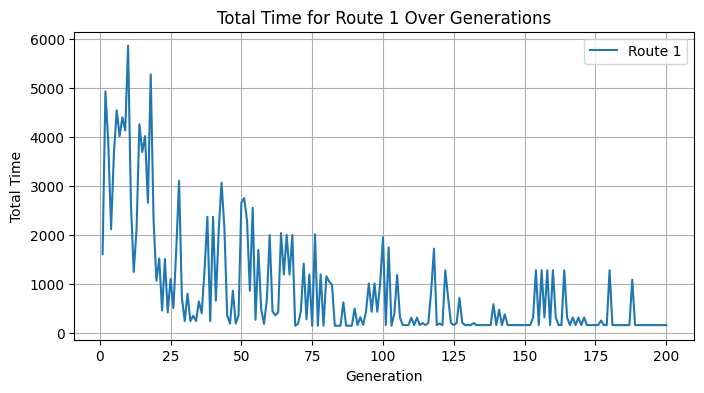

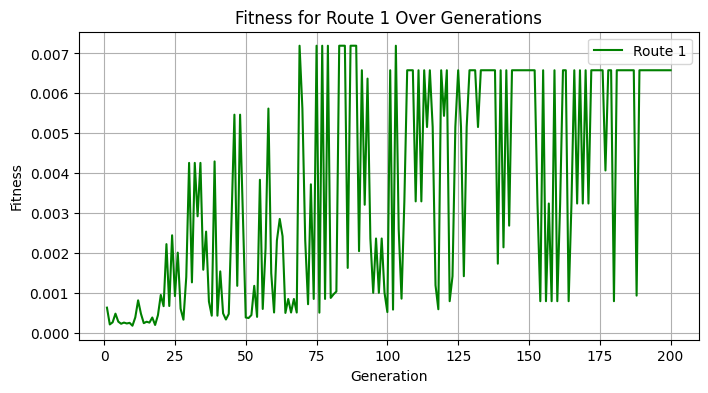


Route 2:

Generation 1: Total Time - 2145, Total Fitness - 0.00046620046402703745
Generation 2: Total Time - 5031, Total Fitness - 0.00019876764023302
Generation 3: Total Time - 4731, Total Fitness - 0.00021137180255469923
Generation 4: Total Time - 1544, Total Fitness - 0.0006476683895876399
Generation 5: Total Time - 4615, Total Fitness - 0.00021668472325745458
Generation 6: Total Time - 3734, Total Fitness - 0.00026780931904710946
Generation 7: Total Time - 4263, Total Fitness - 0.00023457658870613046
Generation 8: Total Time - 3669, Total Fitness - 0.0002725538286384469
Generation 9: Total Time - 3936, Total Fitness - 0.00025406504000491603
Generation 10: Total Time - 3019, Total Fitness - 0.0003312355073493358
Generation 11: Total Time - 5786, Total Fitness - 0.0001728309710113533
Generation 12: Total Time - 1076, Total Fitness - 0.0009293680211025277
Generation 13: Total Time - 5786, Total Fitness - 0.0001728309710113533
Generation 14: Total Time - 3615, Total Fitness - 0.000276

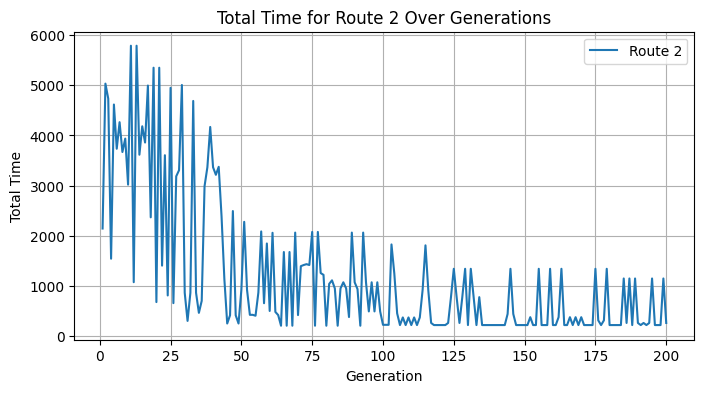

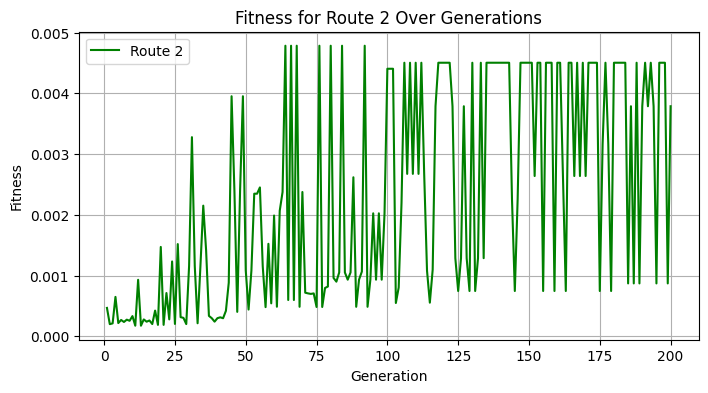


Route 3:

Generation 1: Total Time - 5844, Total Fitness - 0.0001711156739029506
Generation 2: Total Time - 2006, Total Fitness - 0.0004985044840553117
Generation 3: Total Time - 2280, Total Fitness - 0.00043859648930440133
Generation 4: Total Time - 4072, Total Fitness - 0.00024557956717686743
Generation 5: Total Time - 2521, Total Fitness - 0.00039666798731984135
Generation 6: Total Time - 2159, Total Fitness - 0.00046317739479769616
Generation 7: Total Time - 2323, Total Fitness - 0.00043047782853862315
Generation 8: Total Time - 2949, Total Fitness - 0.00033909799817192945
Generation 9: Total Time - 6135, Total Fitness - 0.00016299918473838764
Generation 10: Total Time - 4041, Total Fitness - 0.0002474634985214959
Generation 11: Total Time - 3900, Total Fitness - 0.0002564102557527942
Generation 12: Total Time - 2233, Total Fitness - 0.0004478280320294311
Generation 13: Total Time - 4062, Total Fitness - 0.00024618414513494794
Generation 14: Total Time - 1926, Total Fitness - 0.00

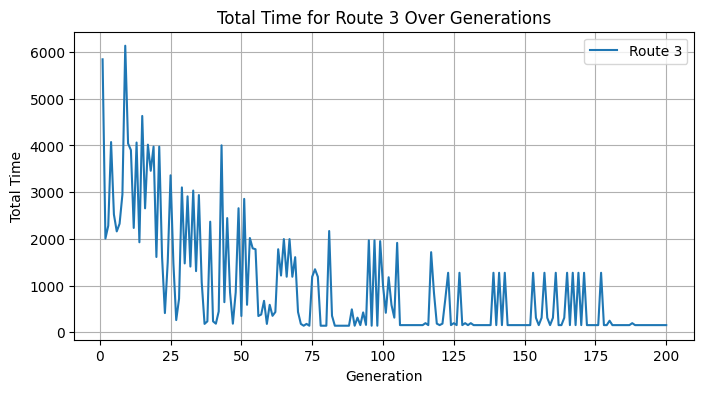

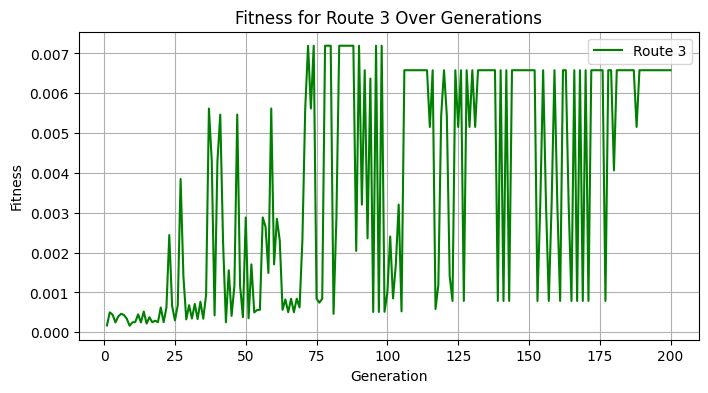


Route 4:

Generation 1: Total Time - 5300, Total Fitness - 0.0001886792449270203
Generation 2: Total Time - 1826, Total Fitness - 0.0005476451229592271
Generation 3: Total Time - 1357, Total Fitness - 0.0007369196703248366
Generation 4: Total Time - 4544, Total Fitness - 0.00022007042205090136
Generation 5: Total Time - 1473, Total Fitness - 0.0006788866213245986
Generation 6: Total Time - 1835, Total Fitness - 0.0005449591250955906
Generation 7: Total Time - 1671, Total Fitness - 0.0005984440419003948
Generation 8: Total Time - 6246, Total Fitness - 0.00016010246532164192
Generation 9: Total Time - 3060, Total Fitness - 0.0003267973845529497
Generation 10: Total Time - 3977, Total Fitness - 0.00025144581279495644
Generation 11: Total Time - 4118, Total Fitness - 0.00024283632772502108
Generation 12: Total Time - 3502, Total Fitness - 0.0002855511128339488
Generation 13: Total Time - 3989, Total Fitness - 0.0002506893952101043
Generation 14: Total Time - 5724, Total Fitness - 0.000174

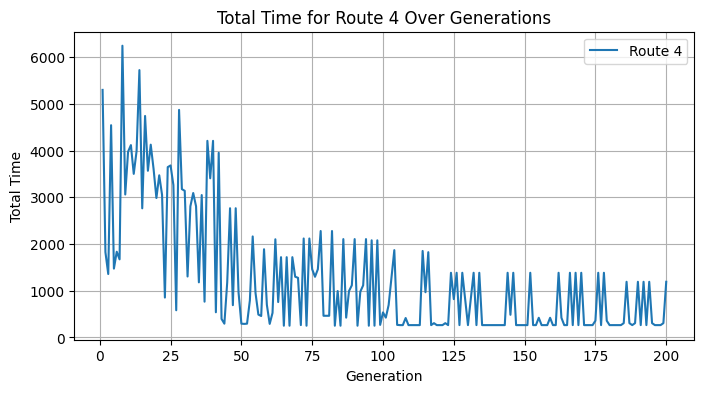

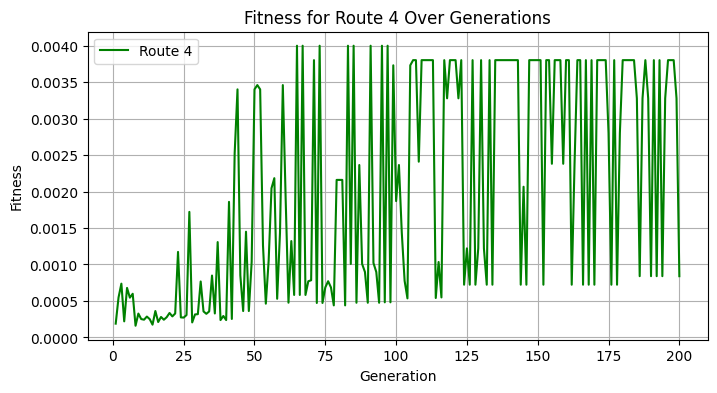


Route 5:

Generation 1: Total Time - 5830, Total Fitness - 0.00017152658632671255
Generation 2: Total Time - 3209, Total Fitness - 0.00031162355776994836
Generation 3: Total Time - 6625, Total Fitness - 0.000150943395998576
Generation 4: Total Time - 4476, Total Fitness - 0.00022341376178861984
Generation 5: Total Time - 5770, Total Fitness - 0.00017331022500292857
Generation 6: Total Time - 2673, Total Fitness - 0.0003741114838230023
Generation 7: Total Time - 6046, Total Fitness - 0.00016539861037810353
Generation 8: Total Time - 1471, Total Fitness - 0.0006798096486756652
Generation 9: Total Time - 1503, Total Fitness - 0.0006653359902505922
Generation 10: Total Time - 2840, Total Fitness - 0.0003521126748165046
Generation 11: Total Time - 3476, Total Fitness - 0.00028768699572011795
Generation 12: Total Time - 3901, Total Fitness - 0.0002563445263872224
Generation 13: Total Time - 3414, Total Fitness - 0.0002929115398567324
Generation 14: Total Time - 1029, Total Fitness - 0.00097

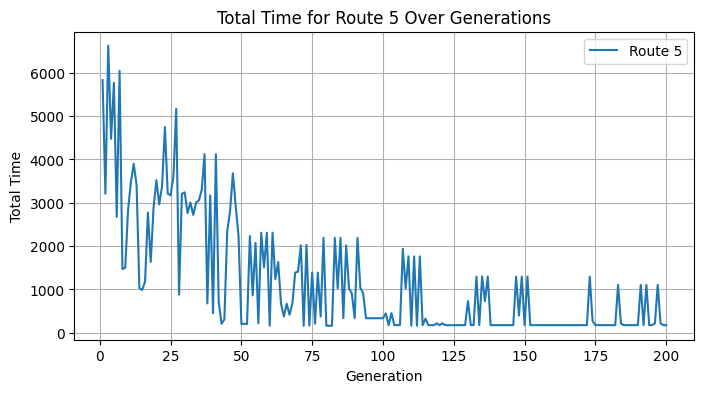

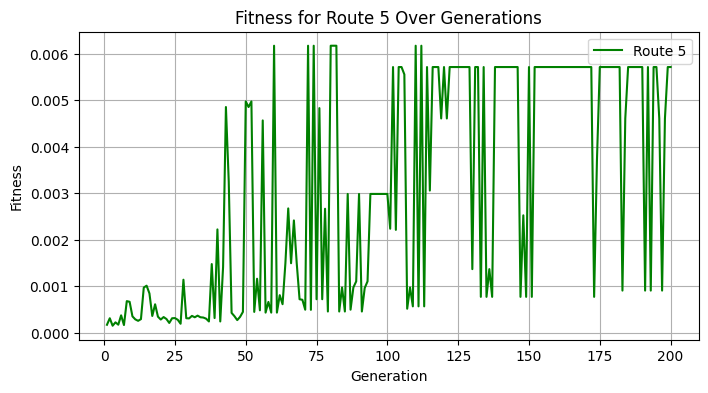


Route 6:

Generation 1: Total Time - 4950, Total Fitness - 0.0002020202016120804
Generation 2: Total Time - 6986, Total Fitness - 0.0001431434295116756
Generation 3: Total Time - 2895, Total Fitness - 0.000345423142157433
Generation 4: Total Time - 5789, Total Fitness - 0.00017274140581664986
Generation 5: Total Time - 2989, Total Fitness - 0.00033456005241030425
Generation 6: Total Time - 6086, Total Fitness - 0.000164311534399751
Generation 7: Total Time - 2713, Total Fitness - 0.0003685956492126957
Generation 8: Total Time - 1543, Total Fitness - 0.0006480881357868559
Generation 9: Total Time - 1511, Total Fitness - 0.0006618133642500771
Generation 10: Total Time - 3462, Total Fitness - 0.00028885037467114274
Generation 11: Total Time - 2826, Total Fitness - 0.00035385704050298287
Generation 12: Total Time - 4071, Total Fitness - 0.00024563989131505797
Generation 13: Total Time - 2242, Total Fitness - 0.00044603032807301367
Generation 14: Total Time - 1029, Total Fitness - 0.000971

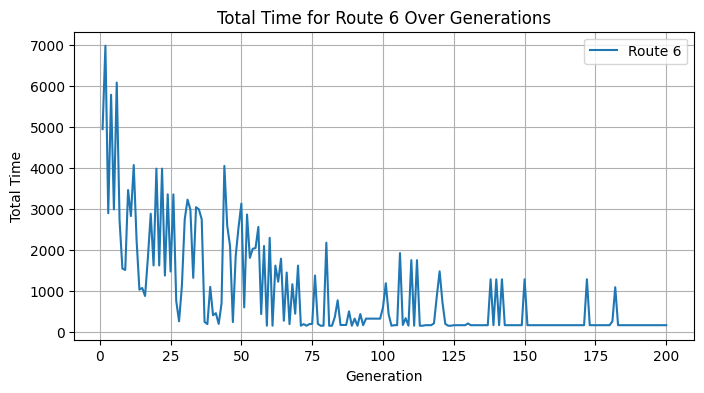

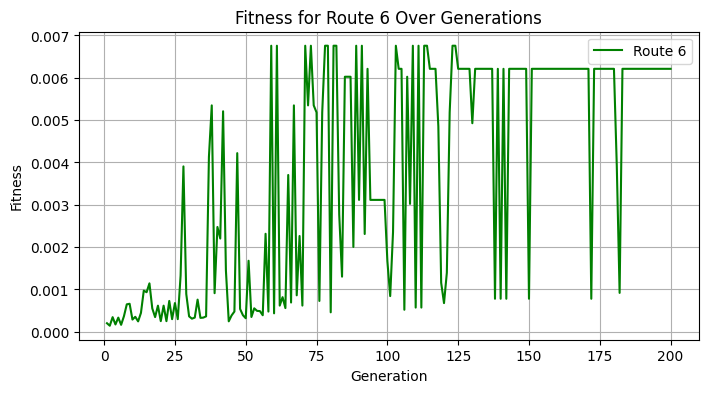


Route 7:

Generation 1: Total Time - 4293, Total Fitness - 0.00023293733931298083
Generation 2: Total Time - 6314, Total Fitness - 0.0001583782069078584
Generation 3: Total Time - 4490, Total Fitness - 0.00022271714872446071
Generation 4: Total Time - 6639, Total Fitness - 0.00015062509391380465
Generation 5: Total Time - 4966, Total Fitness - 0.0002013693109114593
Generation 6: Total Time - 4952, Total Fitness - 0.00020193861025456664
Generation 7: Total Time - 3863, Total Fitness - 0.00025886616552196176
Generation 8: Total Time - 4457, Total Fitness - 0.00022436616507882844
Generation 9: Total Time - 3109, Total Fitness - 0.0003216468307441401
Generation 10: Total Time - 1544, Total Fitness - 0.0006476683895876399
Generation 11: Total Time - 1043, Total Fitness - 0.0009587727616608556
Generation 12: Total Time - 5753, Total Fitness - 0.00017382235325252504
Generation 13: Total Time - 1043, Total Fitness - 0.0009587727616608556
Generation 14: Total Time - 3428, Total Fitness - 0.000

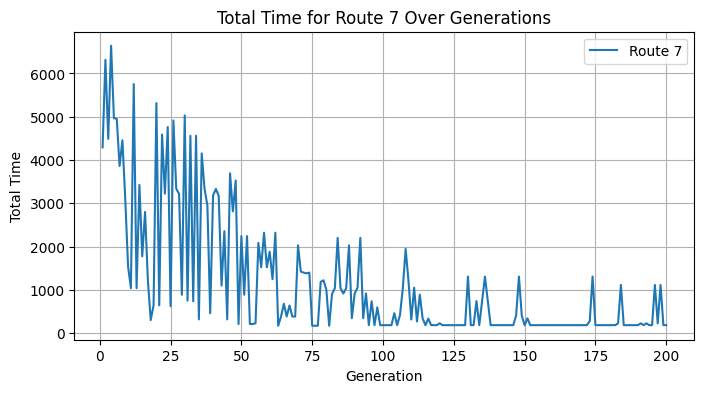

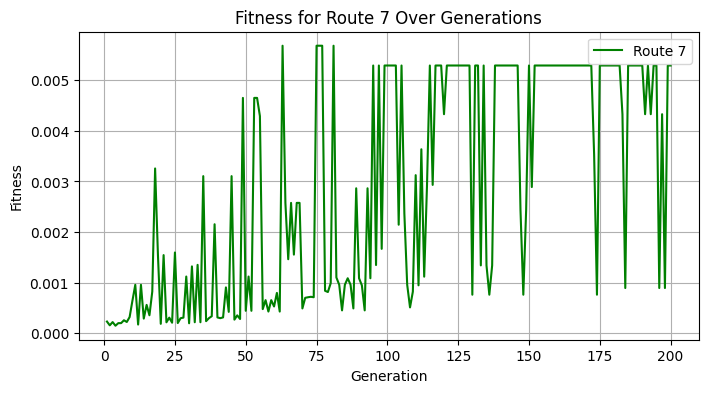


Route 8:

Generation 1: Total Time - 7252, Total Fitness - 0.00013789299484570741
Generation 2: Total Time - 4755, Total Fitness - 0.00021030494172385924
Generation 3: Total Time - 6082, Total Fitness - 0.00016441959854584086
Generation 4: Total Time - 2807, Total Fitness - 0.0003562522253072596
Generation 5: Total Time - 4815, Total Fitness - 0.0002076843194025248
Generation 6: Total Time - 4128, Total Fitness - 0.00024224806142866267
Generation 7: Total Time - 4794, Total Fitness - 0.00020859407549312877
Generation 8: Total Time - 3278, Total Fitness - 0.00030506406252268437
Generation 9: Total Time - 3978, Total Fitness - 0.00025138260369184865
Generation 10: Total Time - 1308, Total Fitness - 0.0007645259880387921
Generation 11: Total Time - 1415, Total Fitness - 0.0007067137759242843
Generation 12: Total Time - 2425, Total Fitness - 0.000412371132320119
Generation 13: Total Time - 1149, Total Fitness - 0.0008703220115724804
Generation 14: Total Time - 2030, Total Fitness - 0.0004

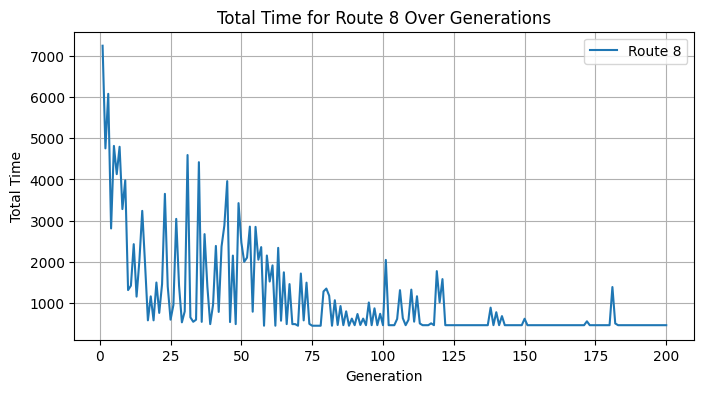

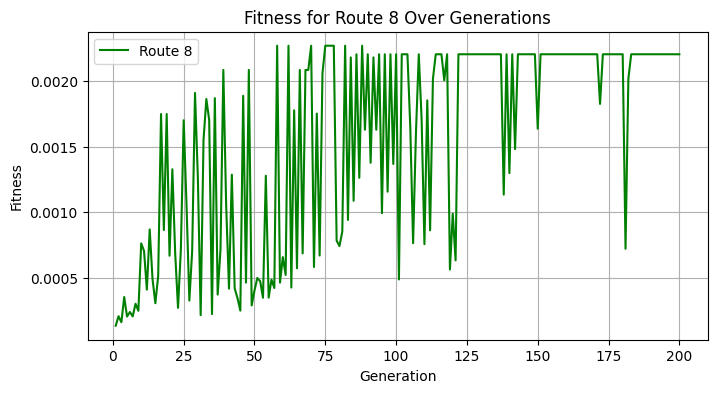


Top 3 Routes:
Route 1: Total Fitness - 0.0008396305555026822
Nodes in Route 1: {'192.168.1.29', '192.168.1.42', '192.168.1.43', '192.168.1.25', '192.168.1.8', '192.168.1.1', '192.168.1.100', '192.168.1.21', '192.168.1.3', '192.168.1.23', '192.168.1.16'}
Route 2: Total Fitness - 0.002202643123289799
Nodes in Route 2: {'192.168.1.29', '192.168.1.100', '192.168.1.1'}
Route 3: Total Fitness - 0.0037878786443985364
Nodes in Route 3: {'192.168.1.29', '192.168.1.15', '192.168.1.100', '192.168.1.1'}
Route 4: Total Fitness - 0.0052910050110579355
Nodes in Route 4: {'192.168.1.29', '192.168.1.100', '192.168.1.1'}

Route 1 Fitness: 0.006578946935595596

Route 2 Fitness: 0.0037878786443985364

Route 3 Fitness: 0.006578946935595596

Route 4 Fitness: 0.0008396305555026822

Route 5 Fitness: 0.005714285387755121

Route 6 Fitness: 0.006211179738436041

Route 7 Fitness: 0.0052910050110579355

Route 8 Fitness: 0.002202643123289799
Simulation completed.


In [ ]:
def main():
    generations_to_run = 200

    # INITIALIZING THE ROUTES POPULATION
    way = [initialize() for _ in range(routeQtd)]

    print(f"Generation 0:\n\n")  # Initial generation
    show(way)

    print(f"Do you want to continue route crossover? 1-yes, 0-no (Remaining generations: {generations_to_run}) ")
    user_input = input().strip()
    continue_execution = int(user_input)
    print("\n\n")

    if continue_execution == 1:
        total_times_history, route_fitnesses_history = collect_generations_history(way, generations_to_run)

        # Print Total Time and Total Fitness for each route
        for route_num in range(1, len(way) + 1):
            route_label = f'Route {route_num}'
            print(f"\n{route_label}:\n")

            total_times = total_times_history[route_label]
            route_fitnesses = route_fitnesses_history[route_label]

            for generation, (total_time, fitness) in enumerate(zip(total_times, route_fitnesses), start=1):
                print(f"Generation {generation}: Total Time - {total_time}, Total Fitness - {fitness}")

            # Plot Total Time for each route after all GA is complete
            plot_total_time(range(1, generations_to_run + 1), total_times, route_num)

            # Plot Fitness Values for each route after GA is complete
            plot_fitness_values(range(1, generations_to_run + 1), route_fitnesses, route_num)

        # Select and print the top 3 routes
        top_routes = select_top_routes(way, top_n=4)
        print("\nTop 3 Routes:")
        for i, route in enumerate(top_routes, start=1):
            print(f"Route {i}: Total Fitness - {route.fitnessSum}")

            # Find and print all nodes in the route
            nodes_in_route = find_nodes_in_route(route)
            print(f"Nodes in Route {i}: {nodes_in_route}")

        for route_num, route in enumerate(way, start=1):
            print(f"\nRoute {route_num} Fitness: {route.fitnessSum}")

    print("Simulation completed.")

if __name__ == "__main__":
    main()

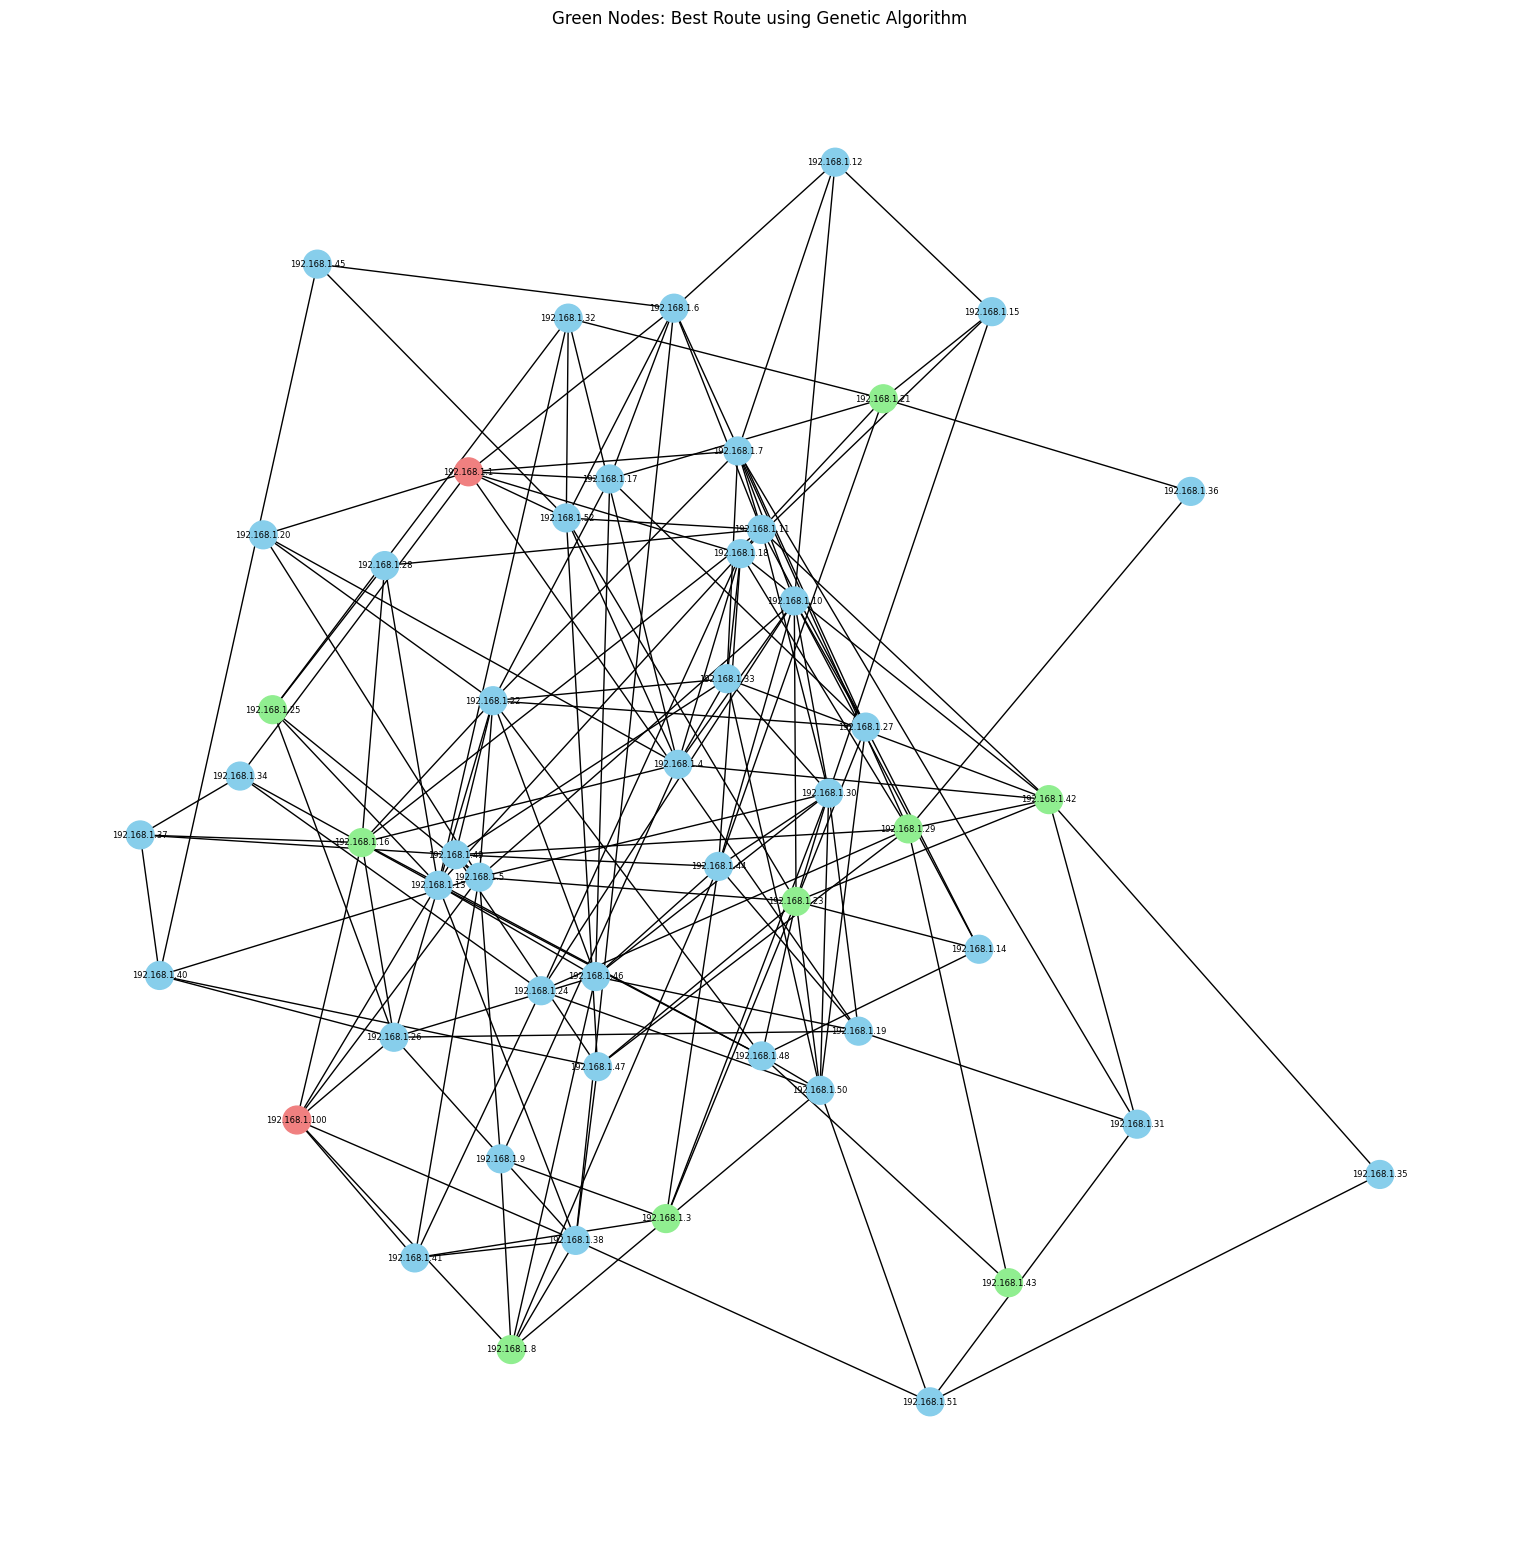

In [ ]:
# Function to highlight the selected GA nodes
def plot_routes_with_color(way, colored_ips):
    G = nx.Graph()

    for i, route in enumerate(way):
        aux = route.firstRouter

        while aux is not None:
            G.add_node(aux.ip)

            if aux.nextRtd is not None:
                G.add_edge(aux.ip, aux.nextRtd.ip, weight=aux.nextTime)

            aux = aux.nextRtd

    plt.figure(figsize=(15, 15))

    pos = nx.spring_layout(G, scale=0.9)

    # Color nodes based on conditions
    node_colors = []
    for node_ip in G.nodes:
        if node_ip in ["192.168.1.1", "192.168.1.100"]:
            node_colors.append("lightcoral")
        elif node_ip in colored_ips:
            node_colors.append("lightgreen")
        else:
            node_colors.append("skyblue")

    nx.draw(G, pos, with_labels=True, node_size=400, node_color=node_colors, font_size=6)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={}, font_size=6)

    plt.title("Green Nodes: Best Route using Genetic Algorithm")
    plt.show()

colored_ips = {'192.168.1.29', '192.168.1.42', '192.168.1.43', '192.168.1.25', '192.168.1.8', '192.168.1.1', '192.168.1.100', '192.168.1.21', '192.168.1.3', '192.168.1.23', '192.168.1.16'}

way_generation_0 = [initialize() for _ in range(routeQtd)]
plot_routes_with_color(way_generation_0, colored_ips)


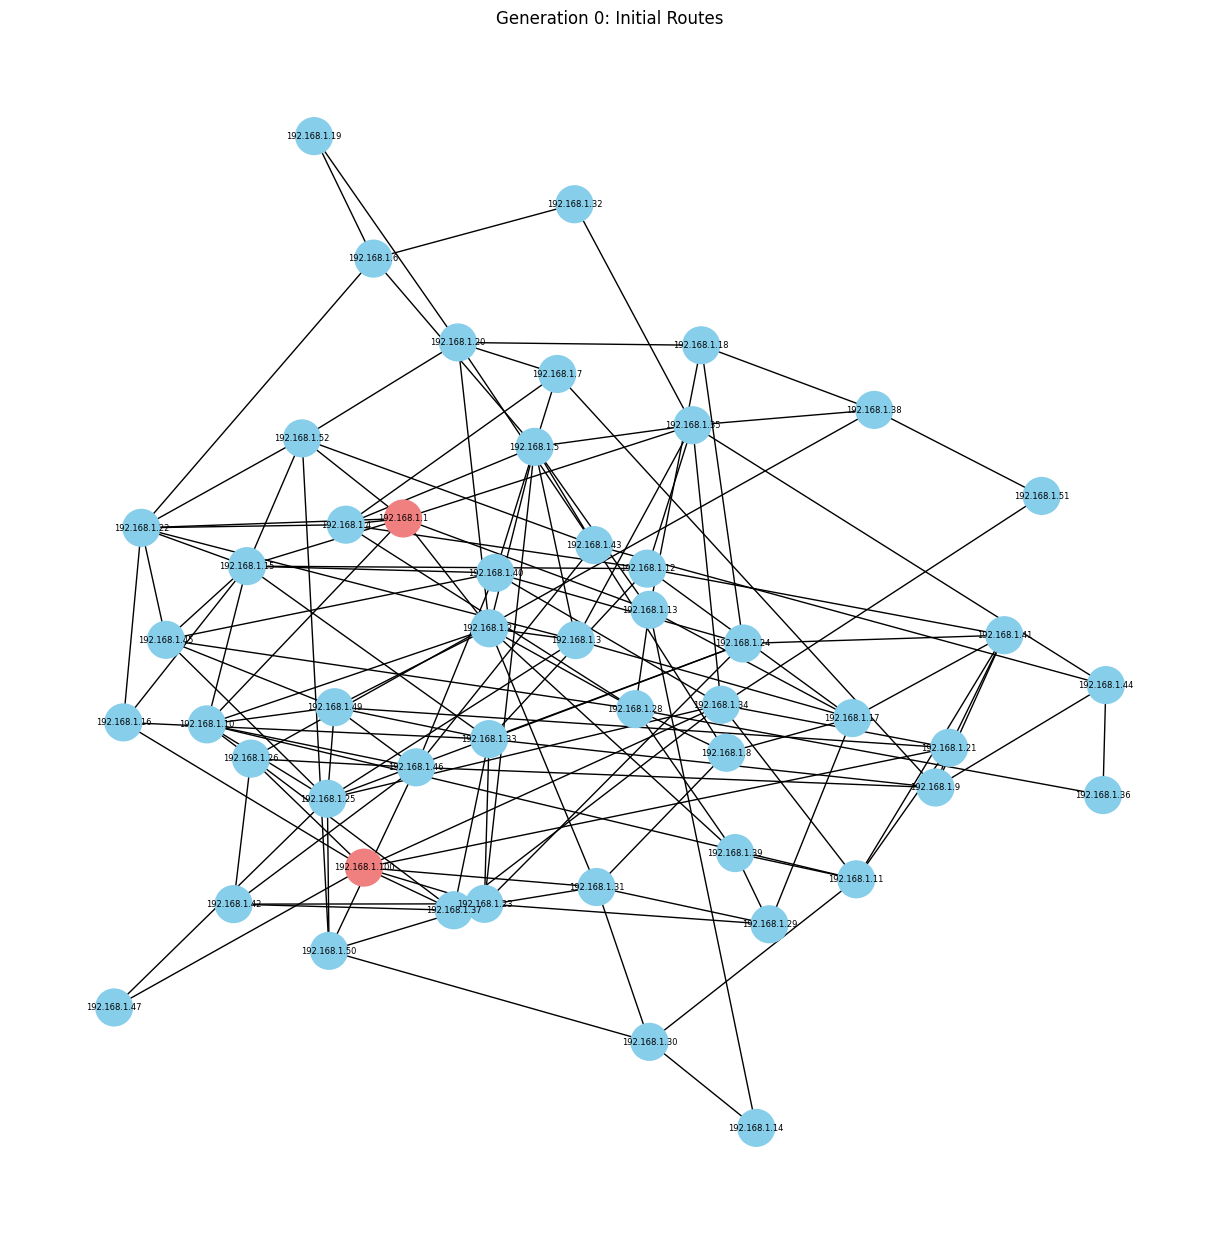

In [ ]:
# Function to create a graph and visualize the initial routes in a genetic algorithm - Generation 0 routes and nodes

def plot_routes(way):
    G = nx.Graph()

    for i, route in enumerate(way):
        aux = route.firstRouter

        while aux is not None:
            G.add_node(aux.ip)
            if aux.nextRtd is not None:
                G.add_edge(aux.ip, aux.nextRtd.ip, weight=aux.nextTime)

            aux = aux.nextRtd

    plt.figure(figsize=(12, 12))

    pos = nx.spring_layout(G, scale=0.9)

    node_colors = ["lightcoral" if node_ip in ["192.168.1.1", "192.168.1.100"] else "skyblue" for node_ip in G.nodes]

    nx.draw(G, pos, with_labels=True, node_size=700, node_color=node_colors, font_size=6)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={}, font_size=6)

    plt.title("Generation 0: Initial Routes")
    plt.show()

way_generation_0 = [initialize() for _ in range(routeQtd)]
plot_routes(way_generation_0)


In [ ]:
# Function to find and return all nodes (IP addresses) in a given route
def find_nodes_in_route(route):
    nodes = set()
    iterator = route.firstRouter

    while iterator is not None:
        nodes.add(iterator.ip)
        iterator = iterator.nextRtd
    # Return all nodes (IP addresses) in a given route
    return nodes